In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchaudio
import numpy as np
from torchaudio import functional as F
from torchaudio.utils import download_asset
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.herb.algorithm import get_audio_hat, dereverberate

### Sample Data

In [2]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
sr = 16000

In [3]:
rir, rir_sr = torchaudio.load(SAMPLE_RIR)
rir = rir[:, int(rir_sr * 1.01) : int(rir_sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)
rir = torchaudio.transforms.Resample(rir_sr, sr)(rir)

display.Audio(rir, rate=sr)

In [4]:
speech, speech_sr = torchaudio.load(SAMPLE_SPEECH)
speech = torchaudio.transforms.Resample(speech_sr, sr)(speech)
display.Audio(speech, rate=sr)

In [5]:
augmented = F.fftconvolve(speech, rir)
display.Audio(augmented, rate=sr)

In [6]:
augmented = augmented.to(torch.float64).numpy().sum(axis=0)
augmented = augmented / np.abs(augmented).max()

#### Applying HERB

In [39]:
#result = get_audio_hat(augmented, augmented)
result = dereverberate(augmented)

In [35]:
result

array([-0.00062878, -0.00053858, -0.00057549, ..., -0.00032806,
       -0.00033416, -0.00035022])

In [36]:
display.Audio(result / np.abs(result).max(), rate=sr)

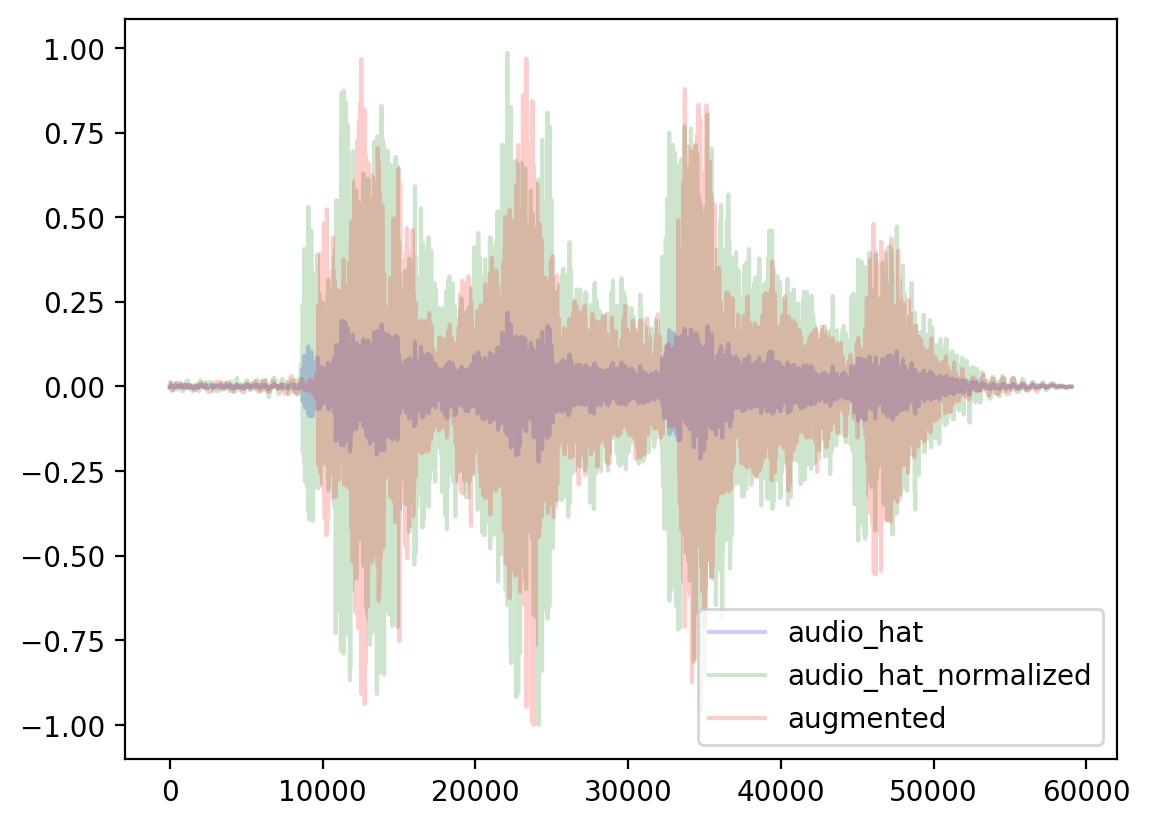

In [37]:
plt.plot(result, color="blue", alpha=0.2, label="audio_hat")
plt.plot(result / np.abs(result).max(), color="green", alpha=0.2, label="audio_hat_normalized")
plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.legend()

In [38]:
plt.plot(np.abs(np.fft.rfft(result))[:1000])